In [4]:


import pandas as pd
import plotly.express as px

# Leer CSV de comparativa
df = pd.read_csv("comparativa_importancia.csv")

# Calcular top diferencias absolutas
df["abs_diff"] = df["diff_importancia"].abs()
df_top = df.sort_values(by="abs_diff", ascending=False).head(20)

# Gráfico interactivo
fig = px.bar(
    df_top,
    y="feature",
    x="diff_importancia",
    orientation="h",
    title="🔍 Diferencia de Importancia entre modelos (con vs sin IDs)",
    labels={"diff_importancia": "Δ Importancia (con - sin)", "feature": "Feature"},
    color="diff_importancia",
    color_continuous_scale="RdBu"
)

fig.update_layout(
    yaxis=dict(autorange="reversed"),
    xaxis_title="Diferencia de Importancia",
    height=600
)

fig.show()


count    335268.000000
mean          0.076628
std           1.321561
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         201.872200
Name: tn, dtype: float64


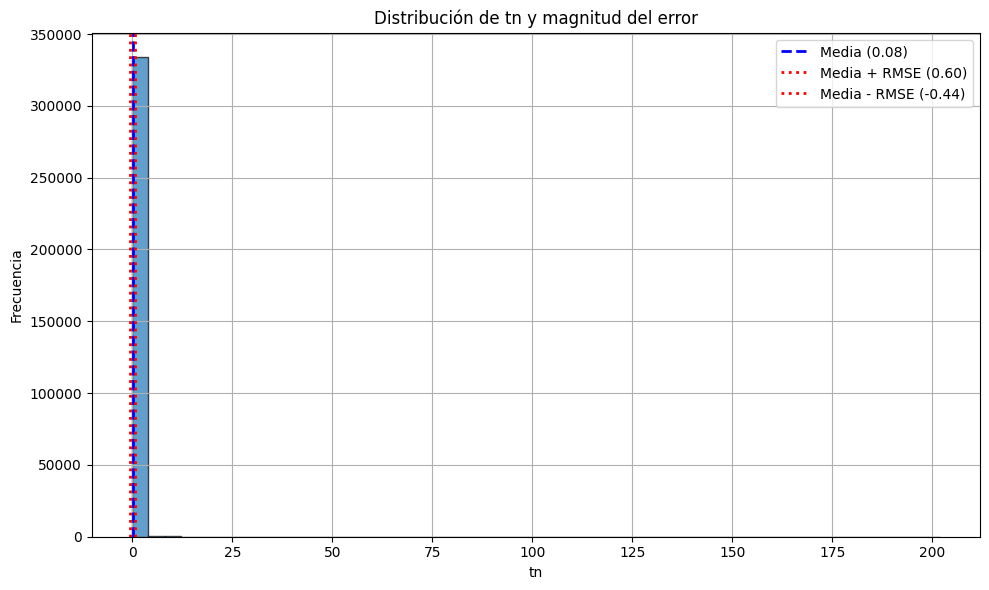

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cargar el dataset
df = pd.read_csv("features_sample_2porciento.csv")

# Ver resumen estadístico de la variable objetivo
print(df["tn"].describe())

# Calcular RMSE (usá el valor real obtenido en tu modelo)
rmse = 0.52

# Graficar distribución
plt.figure(figsize=(10, 6))
plt.hist(df["tn"], bins=50, edgecolor="black", alpha=0.7)
plt.axvline(df["tn"].mean(), color='blue', linestyle='dashed', linewidth=2, label=f"Media ({df['tn'].mean():.2f})")
plt.axvline(df["tn"].mean() + rmse, color='red', linestyle='dotted', linewidth=2, label=f"Media + RMSE ({df['tn'].mean() + rmse:.2f})")
plt.axvline(df["tn"].mean() - rmse, color='red', linestyle='dotted', linewidth=2, label=f"Media - RMSE ({df['tn'].mean() - rmse:.2f})")
plt.title("Distribución de tn y magnitud del error")
plt.xlabel("tn")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


📊 Clasificación binaria (tn > 0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57924
           1       1.00      1.00      1.00      9130

    accuracy                           1.00     67054
   macro avg       1.00      1.00      1.00     67054
weighted avg       1.00      1.00      1.00     67054

Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.951591	valid_1's rmse: 1.26118
Early stopping, best iteration is:
[67]	training's rmse: 0.863215	valid_1's rmse: 1.23682

📈 RMSE sobre casos con tn > 0: 1.2368


C:\Users\waldo\AppData\Local\Temp\ipykernel_33640\4281109877.py:110: UserWarning:

Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.

c:\Users\waldo\miniconda3\envs\lgbmgpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.



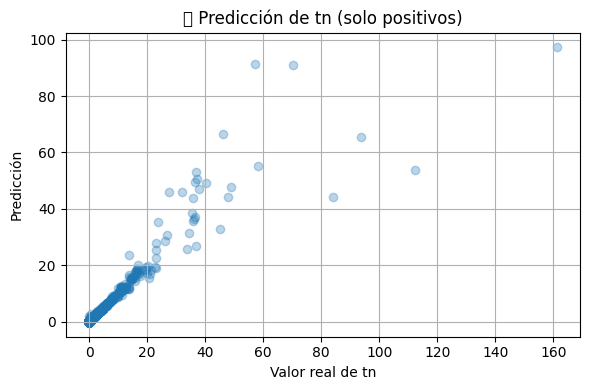

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt

# 1. Cargar dataset
df = pd.read_csv("features_sample_2porciento.csv")

# 2. Crear variable binaria
df["tn_binaria"] = (df["tn"] > 0).astype(int)

# 3. Limpiar columnas innecesarias
df = df.drop(columns=["periodo"], errors="ignore")

# -------------------------
# 🔍 Modelo 1: Clasificador binario
# -------------------------

# a. Definir variables
X_bin = df.drop(columns=["tn", "tn_binaria"])
y_bin = df["tn_binaria"]

# b. Codificar categóricas para sklearn
cat_cols = X_bin.select_dtypes(include=["object", "category"]).columns
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_bin[cat_cols] = encoder.fit_transform(X_bin[cat_cols])

# c. Split
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_bin, y_bin, test_size=0.2, random_state=42)

# d. Modelo y evaluación
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(Xb_train, yb_train)
yb_pred = clf.predict(Xb_test)

print("📊 Clasificación binaria (tn > 0):")
print(classification_report(yb_test, yb_pred))

# -------------------------
# 🔢 Modelo 2: Regresión sobre positivos
# -------------------------

# a. Filtrar positivos
df_pos = df[df["tn"] > 0].copy()
X_reg = df_pos.drop(columns=["tn", "tn_binaria"])
y_reg = df_pos["tn"]
# Limpiar nombres conflictivos para LightGBM
def limpiar_columna(col):
    return (
        col.replace("(", "_")
           .replace(")", "")
           .replace(",", "_")
           .replace(".", "_")
           .replace(" ", "_")
           .replace(":", "_")
           .replace("[", "_")
           .replace("]", "_")
           .replace("{", "_")
           .replace("}", "_")
           .replace("'", "_")
           .replace('"', "_")
    )

X_reg.columns = [limpiar_columna(c) for c in X_reg.columns]

# b. Convertir categóricas para LightGBM
for col in X_reg.select_dtypes(include="object").columns:
    X_reg[col] = X_reg[col].astype("category")

# c. Split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# d. LightGBM dataset
train_data = lgb.Dataset(Xr_train, label=yr_train)
valid_data = lgb.Dataset(Xr_test, label=yr_test)

# e. Parámetros
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.1,
    "verbosity": -1
}

# f. Entrenar modelo
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=500,
    callbacks=[lgb.early_stopping(20), lgb.log_evaluation(50)]
)

# g. Evaluar regresión
yr_pred = model.predict(Xr_test)
rmse = np.sqrt(mean_squared_error(yr_test, yr_pred))
print(f"\n📈 RMSE sobre casos con tn > 0: {rmse:.4f}")

# h. Visualizar
plt.figure(figsize=(6, 4))
plt.scatter(yr_test, yr_pred, alpha=0.3)
plt.xlabel("Valor real de tn")
plt.ylabel("Predicción")
plt.title("🎯 Predicción de tn (solo positivos)")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\waldo\AppData\Local\Temp\ipykernel_28788\49023005.py:28: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

c:\Users\waldo\miniconda3\envs\lgbmgpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



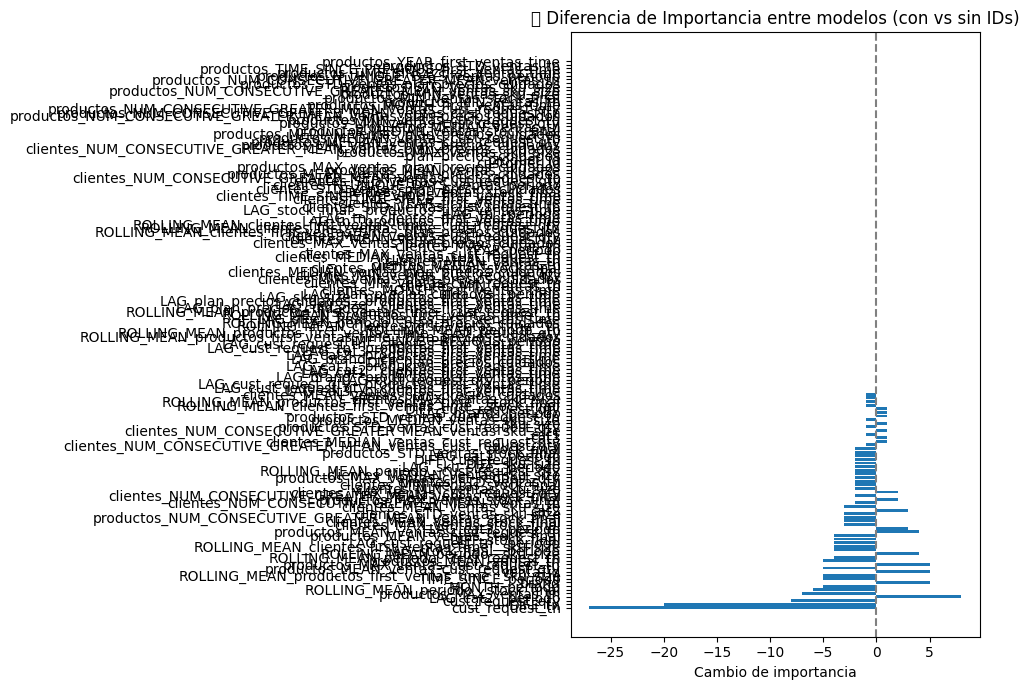

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 📥 Cargar las importancias exportadas desde los dos modelos
# Asegurate de tener estos archivos en el mismo directorio que el notebook
df_sin = pd.read_csv("importancia_sin_ids.csv")
df_con = pd.read_csv("importancia_con_ids_cpu.csv")

# 🔄 Renombrar columnas para un merge claro
df_sin = df_sin.rename(columns={"importance": "importance_sin"})
df_con = df_con.rename(columns={"importance": "importance_con"})

# 🔗 Unir por nombre de feature
df_merge = pd.merge(df_con, df_sin, on="feature", how="outer").fillna(0)

# ➖ Calcular diferencia
df_merge["diferencia"] = df_merge["importance_con"] - df_merge["importance_sin"]

# 🔽 Ordenar por magnitud de diferencia
df_merge = df_merge.sort_values("diferencia", key=abs, ascending=False)

# 📊 Gráfico comparativo
plt.figure(figsize=(10, 7))
plt.barh(df_merge["feature"], df_merge["diferencia"])
plt.axvline(0, color="gray", linestyle="--")
plt.title("📊 Diferencia de Importancia entre modelos (con vs sin IDs)")
plt.xlabel("Cambio de importancia")
plt.tight_layout()
plt.show()


🌟 MAE (todas las features):  0.0007
🌟 RMSE:                     0.0552
🌟 R²:                       0.9982
✅ Exportado como importancia_sin_ids.csv


C:\Users\waldo\AppData\Local\Temp\ipykernel_28788\2894766356.py:48: UserWarning:

Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.



<Figure size 1000x600 with 0 Axes>

c:\Users\waldo\miniconda3\envs\lgbmgpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.



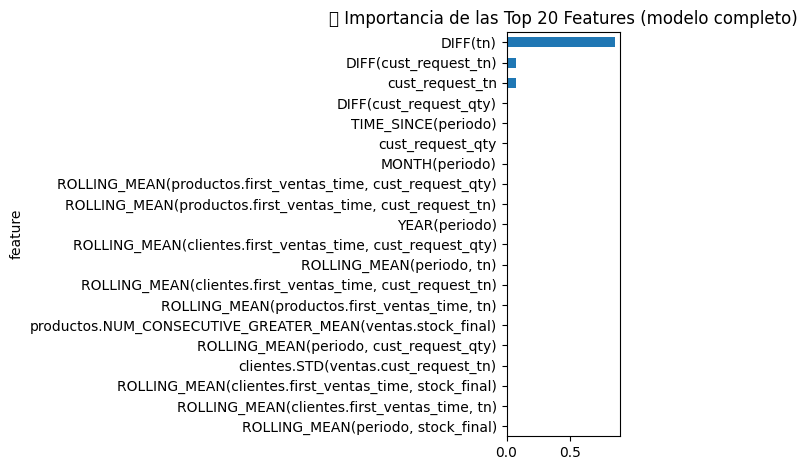

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 📥 1. Cargar dataset completo
df = pd.read_csv("features_sample_2porciento.csv", index_col=0)
y = df["tn"]

# 🧼 2. Filtrar solo columnas numéricas (sin NaNs)
X = df.drop(columns=["tn"]).select_dtypes(include=[np.number]).fillna(0)

# 🧪 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 🌲 4. Entrenar modelo completo
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# 📊 5. Predicción y métricas
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"🌟 MAE (todas las features):  {mae:.4f}")
print(f"🌟 RMSE:                     {rmse:.4f}")
print(f"🌟 R²:                       {r2:.4f}")

# 💾 6. Exportar importancias
importancias = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

importancias.to_csv("importancia_sin_ids.csv", index=False)
print("✅ Exportado como importancia_sin_ids.csv")

# 🎯 7. Gráfico (top 20)
top_importances = importancias.head(20).set_index("feature")
plt.figure(figsize=(10, 6))
top_importances.sort_values("importance").plot(kind="barh", legend=False)
plt.title("🎯 Importancia de las Top 20 Features (modelo completo)")
plt.tight_layout()
plt.show()


🌟 MAE (con IDs):  0.0007
🌟 RMSE:           0.0552
🌟 R²:             0.9982
✅ Exportado como importancia_con_ids.csv


C:\Users\waldo\AppData\Local\Temp\ipykernel_28788\3654713706.py:54: UserWarning:

Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.



<Figure size 1000x600 with 0 Axes>

c:\Users\waldo\miniconda3\envs\lgbmgpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.



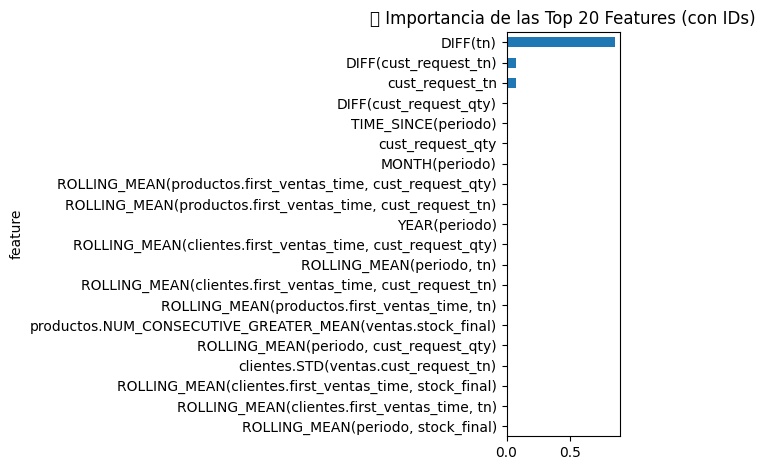

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 📥 1. Cargar dataset
df = pd.read_csv("features_sample_2porciento.csv", index_col=0)
y = df["tn"]

# 🧼 2. Seleccionar todas las columnas numéricas (incluyendo IDs si son numéricas)
X = df.drop(columns=["tn"]).select_dtypes(include=[np.number]).fillna(0)

# ⚠️ Si tus columnas de ID están como object, convertirlas
for col in ["venta_id", "customer_id", "product_id"]:
    if col in df.columns and df[col].dtype == "object":
        df[col] = df[col].astype("category").cat.codes
        X[col] = df[col]

# 🧪 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 🌲 4. Entrenar modelo
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# 📊 5. Evaluar
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"🌟 MAE (con IDs):  {mae:.4f}")
print(f"🌟 RMSE:           {rmse:.4f}")
print(f"🌟 R²:             {r2:.4f}")

# 💾 6. Exportar importancias
importancias = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

importancias.to_csv("importancia_con_ids.csv", index=False)
print("✅ Exportado como importancia_con_ids.csv")

# 📉 7. Gráfico
top_importances = importancias.head(20).set_index("feature")
plt.figure(figsize=(10, 6))
top_importances.sort_values("importance").plot(kind="barh", legend=False)
plt.title("🎯 Importancia de las Top 20 Features (con IDs)")
plt.tight_layout()
plt.show()


C:\Users\waldo\AppData\Local\Temp\ipykernel_28788\3464030298.py:24: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

c:\Users\waldo\miniconda3\envs\lgbmgpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



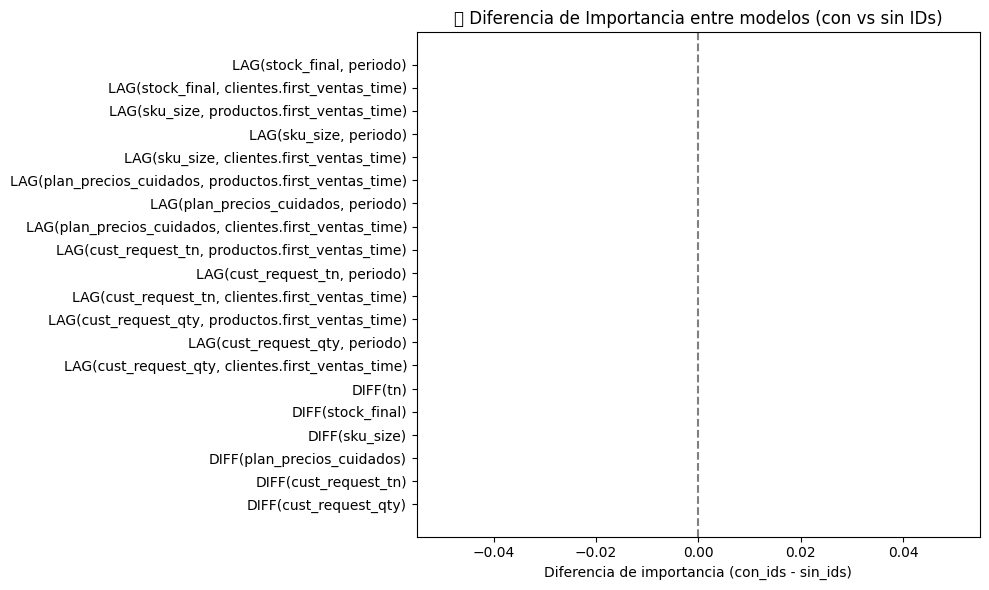

✅ Diferencias exportadas como diferencia_importancia.csv


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 📥 1. Cargar archivos de importancia
df_ids = pd.read_csv("importancia_con_ids.csv")
df_sin_ids = pd.read_csv("importancia_sin_ids.csv")

# 🧱 2. Renombrar columnas
df_ids.rename(columns={"importance": "con_ids"}, inplace=True)
df_sin_ids.rename(columns={"importance": "sin_ids"}, inplace=True)

# 🔗 3. Merge
df_merged = pd.merge(df_ids, df_sin_ids, on="feature", how="outer").fillna(0)
df_merged["diferencia"] = df_merged["con_ids"] - df_merged["sin_ids"]

# 📊 4. Gráfico de diferencias
top_dif = df_merged.sort_values("diferencia", key=abs, ascending=False).head(20)

plt.figure(figsize=(10, 6))
bars = plt.barh(top_dif["feature"], top_dif["diferencia"])
plt.axvline(0, color='gray', linestyle='--')
plt.title("📊 Diferencia de Importancia entre modelos (con vs sin IDs)")
plt.xlabel("Diferencia de importancia (con_ids - sin_ids)")
plt.tight_layout()
plt.show()

# 💾 (Opcional) Guardar resultados
top_dif.to_csv("diferencia_importancia.csv", index=False)
print("✅ Diferencias exportadas como diferencia_importancia.csv")


C:\Users\waldo\AppData\Local\Temp\ipykernel_28788\521793785.py:24: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

c:\Users\waldo\miniconda3\envs\lgbmgpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



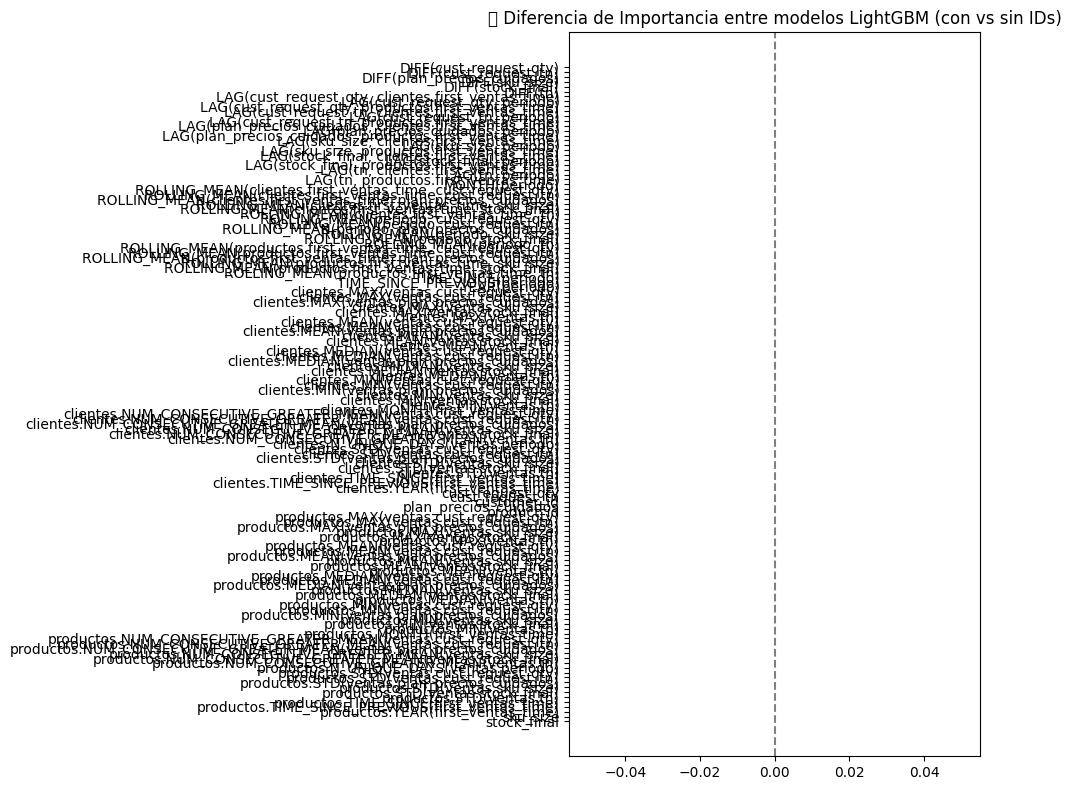

In [12]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

# Cargar rankings de importancia
df_con = pd.read_csv("importancia_con_ids.csv")
df_sin = pd.read_csv("importancia_sin_ids.csv")

# Asegurar nombres consistentes
df_con.columns = ["feature", "importance_con"]
df_sin.columns = ["feature", "importance_sin"]

# Unir y calcular diferencia
df_merge = pd.merge(df_con, df_sin, on="feature", how="outer").fillna(0)
df_merge["diferencia"] = df_merge["importance_con"] - df_merge["importance_sin"]
df_merge["abs_diff"] = df_merge["diferencia"].abs()

# Ordenar y graficar
df_sorted = df_merge.sort_values("abs_diff", ascending=False)
plt.figure(figsize=(10, 8))
plt.barh(df_sorted["feature"], df_sorted["diferencia"])
plt.axvline(0, color="gray", linestyle="--")
plt.title("📊 Diferencia de Importancia entre modelos LightGBM (con vs sin IDs)")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.934036	valid_1's rmse: 1.24834
[100]	training's rmse: 0.721976	valid_1's rmse: 1.24307
Early stopping, best iteration is:
[86]	training's rmse: 0.767269	valid_1's rmse: 1.22575


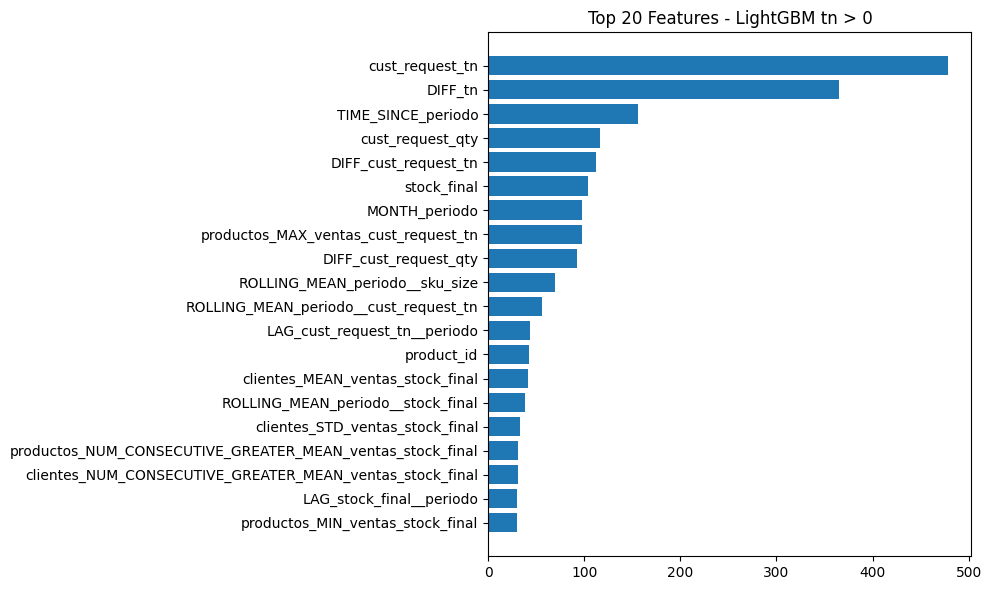

In [17]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os

# 📥 1. Cargar dataset
archivo = "features_sample_2porciento.csv"
df = pd.read_csv(archivo, index_col=0)

# 🔍 2. Filtrar registros con tn > 0
df_pos = df[df["tn"] > 0].copy()

# 🧹 3. Limpiar nombres de columnas
def limpiar_nombre(col):
    return (
        col.replace("(", "_")
           .replace(")", "")
           .replace(",", "_")
           .replace(".", "_")
           .replace(" ", "_")
    )

df_pos.columns = [limpiar_nombre(c) for c in df_pos.columns]

# 🎯 4. Separar variables
y = df_pos["tn"]
X = df_pos.drop(columns=["tn"]).select_dtypes(include=[np.number]).fillna(0)

# 🔀 5. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📦 6. Dataset para LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

# ⚙️ 7. Parámetros base
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.1,
    "num_leaves": 31,
    "verbosity": -1
}

# 🚀 8. Entrenar
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=500,
    callbacks=[
        lgb.early_stopping(20),
        lgb.log_evaluation(50)
    ]
)

# 📊 9. Evaluación
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 📈 10. Mostrar métricas
metricas = {
    "MAE": mae,
    "RMSE": rmse,
    "R²": r2
}

# 🎯 11. Importancia de variables
importancia = pd.DataFrame({
    "feature": model.feature_name(),
    "importance": model.feature_importance()
}).sort_values(by="importance", ascending=False)

# 📉 12. Gráfico de importancia
plt.figure(figsize=(10, 6))
plt.barh(importancia["feature"].head(20)[::-1], importancia["importance"].head(20)[::-1])
plt.title("Top 20 Features - LightGBM tn > 0")
plt.tight_layout()


